# 🌱 **Multi-class Weed Image Classification Project Using Deep Learning**🌾

##🌟 Project Overview

Weed infestation is a critical challenge in sustainable agriculture, impacting crop yields and increasing reliance on herbicides. This project addresses the need for precise weed identification by leveraging deep learning to classify 8 distinct weed categories using over 17,000 RGB images. The project also features a user-friendly web application interface developed using Streamlit for real-time weed classification.

##🔍 Objective

The goal is to develop a model that can help farmers automate the identification of various weed species, reducing manual effort and improving crop yield. We'll architect our classifier and build a model using PyTorch.  Our aim is to achieve the best accuracy possible and eventually make our classifier available for everyone to use through our Streamlit application.

We experimented on weed datasets by DeepWeed using three different CNN architectures namely ResNet-50, ResNet-34 and Inception-v3, and compare their results.

**We're going to go through the following Deep Learning workflow:**

1. Get data ready (download from TensorFlow dataset/GitHub, store, import,etc.).
2. Prepare the data (preprocessing, the 3 sets).
3. Choose and fit/train a model (PyTorch, Torchvision).
4. Build **ResNet-50** from scratch, and finetune it to test on our dataset.
5. Also finetune pre-trained **ResNet-34** and **Inception-V3** models (Transfer Learning) to test on our dataset, and compare the results.
6. Evaluating the models (making predictions, comparing them with the ground truth labels).
7. Improve the models through experimentation.
8. Testing our model's accuracy with our Validation set.
9. Saving our model (once we're happy with the results).
10. Exporting our model to use with our Streamlit Application.

In this **particular notebook** we'll load the dataset,explore them and then do some analysis on them.

After that we'll construct our CNN architecture (i.e the ResNet-50 from scratch), test our model on the given dataset, and evaluate our results.


#Data Preparation and Exploration:-

The **Deep weeds** dataset is an in-situ datasets (taken from real farms) capturing the realistic view of the entire plant. It consists of around 17,509 images of eight different weed plants with other flora. The selected sample is from the state of Queensland in Australia.

For a detailed description of the dataset refer this link:
 https://github.com/AlexOlsen/DeepWeeds.

The selected weed species are local to pastoral grasslands across the state of Queensland.
They include: "Chinee apple", "Snakeweed", "Lantana", "Prickly acacia", "Siam weed", "Parthenium", "Rubber vine" and "Parkinsonia".

Over 1,000 images were collected of each weed species, totaling over 8,000 images of positive species classes. Images of neighbouring flora and backgrounds that did not contain the weed species of interest were collated into a single “negative” class.

##Loading the dataset

The images and datasets are provided on GitHub here: https://github.com/AlexOlsen/DeepWeeds/tree/master . And the labels are provided here: https://github.com/AlexOlsen/DeepWeeds/tree/master/labels .

On the other hand, they can also be downloaded from TesnsorFlow dataset hub: https://www.tensorflow.org/datasets/catalog/deep_weeds .

As we've run most of our models on Kaggle, so we've downloaded the datasets from GitHub and loaded all on the kaggle account.

In [ ]:
!pip install torchvision

##Splitting the data

All 17,509 labelled images from DeepWeeds were partitioned into 60%-20%-20% splits of training, validation and testing
subsets for k-fold cross validation with k = 5.

More in details about the process is mentioned here of the research paper: https://pmc.ncbi.nlm.nih.gov/articles/PMC6375952/#Sec2 .

In [ ]:
+import tensorflow_datasets as tfds
import logging
from zipfile import ZipFile
import os
import sys
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os
os.listdir('/kaggle/input')

['train_subset1.csv',
 'test_subset1.csv',
 'val_subset0.csv',
 'test_subset0.csv',
 'train_subset0.csv',
 'images',
 'val_subset1.csv',
 'labels.csv']

In [ ]:
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
from torchvision import transforms
import torchvision
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from PIL import ImageFile

##Exploring the data

In [ ]:
labels_file = pd.read_csv('/kaggle/input/labels.csv')
labels_file

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


 *Note: The specific label subsets of training (60%), validation (20%) and testing (20%) for the five-fold cross validation used in the research paper are also provided as CSV files in the same format as "labels.csv".*

In [ ]:
# Find the number of species in each class

species_counts = labels_file['Species'].value_counts()
print(species_counts)

Species
Negative          9106
Chinee apple      1125
Siam weed         1074
Lantana           1064
Prickly acacia    1062
Parkinsonia       1031
Parthenium        1022
Snake weed        1016
Rubber vine       1009
Name: count, dtype: int64


In [ ]:
# Calculating the distribution of labels
label_distribution = labels_file['Label'].value_counts().reset_index()
label_distribution.columns = ['Label', 'Count']
print(label_distribution)

   Label  Count
0      8   9106
1      0   1125
2      6   1074
3      1   1064
4      4   1062
5      2   1031
6      3   1022
7      7   1016
8      5   1009


##Visualizing the data

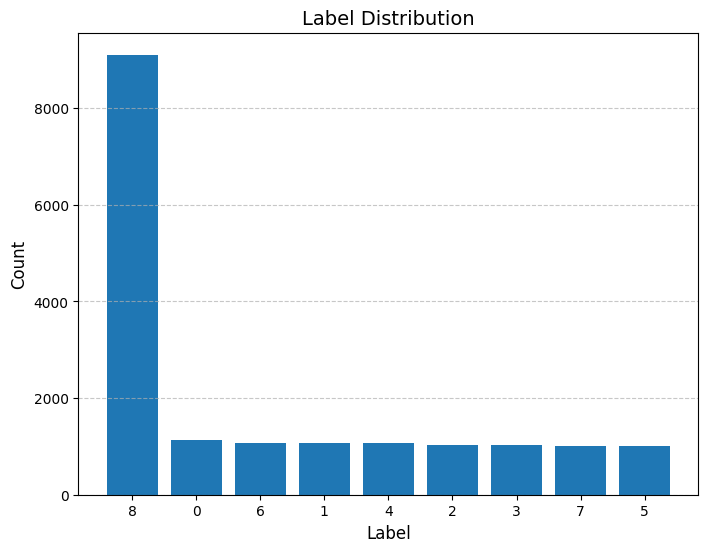

In [ ]:
# Plotting the label distribution

plt.figure(figsize=(8, 6))
plt.bar(label_distribution['Label'].astype(str), label_distribution['Count'])
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Label Distribution', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [ ]:
##Distribution of labels alongwith its species in each class

# Group by 'Label' and 'Species' and count the occurrences
label_species_distribution = labels_file.groupby(['Label', 'Species'])['Species'].count().reset_index(name='Count')

# Print the distribution
print(label_species_distribution)

   Label         Species  Count
0      0    Chinee apple   1125
1      1         Lantana   1064
2      2     Parkinsonia   1031
3      3      Parthenium   1022
4      4  Prickly acacia   1062
5      5     Rubber vine   1009
6      6       Siam weed   1074
7      7      Snake weed   1016
8      8        Negative   9106


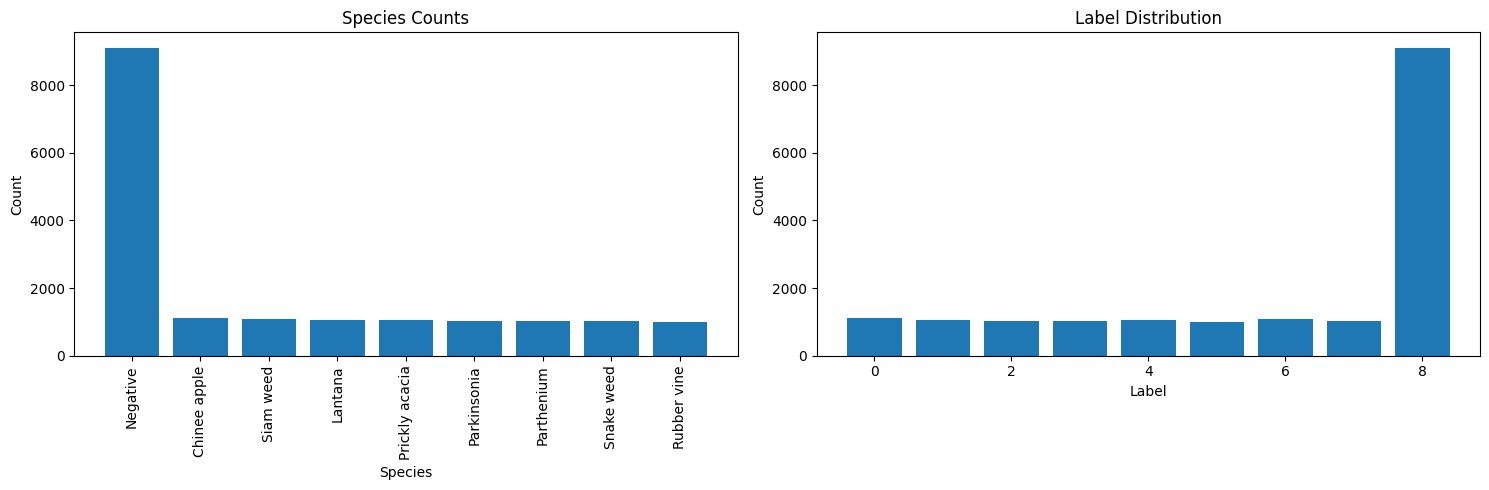

In [ ]:
# spceies_counts and label_distribution in a single plot

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot species counts
axs[0].bar(species_counts.index, species_counts.values)
axs[0].set_title('Species Counts')
axs[0].set_xlabel('Species')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=90)

# Plot label distribution
axs[1].bar(label_distribution['Label'], label_distribution['Count'])
axs[1].set_title('Label Distribution')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

* From bar charts and data, it's clear there's a **class imbalance** issue, with the "Negative" class having significantly more samples (9106) compared to other species (around 1000-1100 each).

##Applying Image Transformations


* We'll, now, apply **image transformations** to prepare the data for training and testing in our deep learning model. These transformations help to improve the model’s performance and generalization

* Additionally, in both phases, we **normalize** the images using the mean and standard deviation values derived from the ImageNet dataset. This normalization step adjusts the pixel values to a common scale, which can expedite the training process and enhance model performance.

In [ ]:
# Custom dataset class

class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.data_frame.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label


# Load the CSV file
train_csv_file = '/kaggle/input/train_subset0.csv'  # Replace with your actual path
test_csv_file = '/kaggle/input/test_subset0.csv'  # Replace with your actual path
val_csv_file = '/kaggle/input/val_subset0.csv'  # Replace with your actual path
img_dir = '/kaggle/input/images'  # Replace with your images directory


# Image transformations (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resizing to 128x128, you can adjust this
    transforms.ToTensor(),  #Converts the image into a PyTorch tensor and scales pixel values to [0, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  #Normalizes the image with a mean and standard deviation of [0.5, 0.5, 0.5] for the three RGB channels.
  ])


# Create the train, val and test datasets
train_dataset = ImageDataset(csv_file=train_csv_file, img_dir=img_dir, transform=transform)
test_dataset = ImageDataset(csv_file=test_csv_file, img_dir=img_dir, transform=transform)
val_dataset = ImageDataset(csv_file=val_csv_file, img_dir=img_dir, transform=transform)


# Create DataLoaders for batching
def create_dataloader(loader_type):
  if loader_type=='train':
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    #inspecting batch size for 'training dataset'
    print(f"len train_loader {len(train_loader)}")  #Prints the no. of batches in the training DataLoader
    return train_loader
  elif loader_type=='val':
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    return val_loader
  else:
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    return test_loader


# Defining DataLoaders: Call the function to create the DataLoaders before using them
train_loader = create_dataloader('train') # This line is crucial to define train_loader
val_loader = create_dataloader('val')
test_loader = create_dataloader('test')

len train_loader 657


In [ ]:
# Checking & printing the size of datasets

num_train_samples = len(train_dataset)
num_val_samples = len(val_dataset)
num_test_samples = len(test_dataset)
print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of testing samples: {num_test_samples}")

Number of training samples: 10501
Number of validation samples: 3501
Number of testing samples: 3507


Visualizing Sample Weed Images:

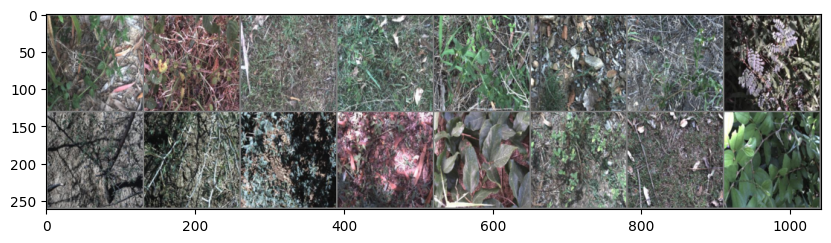

Labels: tensor([6, 1, 8, 8, 6, 8, 6, 8, 4, 8, 4, 8, 8, 8, 8, 0])


In [ ]:
##Plot images

# Function to display a batch of images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image (reversing the normalization step)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose to match the image format (H, W, C)
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use next() directly on the iterator

# Plot images
plt.figure(figsize=(10, 10))  # Set the figure size
imshow(torchvision.utils.make_grid(images))

# Print corresponding labels
print('Labels:', labels)

# Constructing the ResNet-50 Model from scratch:-

Instead of fine-tuning pre-trained ResNet-50 model, we will build the architecture from scratch and then later compare its result with pre-trained ResNet-34 and Inception-v3 models.

Let us first create a code that defines a BottleNeck class in PyTorch, which represents the bottleneck building block of a ResNet-like architecture.

##The Model

In [ ]:
from torch import nn

class BottleNeck(nn.Module):
    def __init__(self, in_channel,out_channel,stride=1, downsample=None):
        super(BottleNeck,self).__init__()
        ##Layers Initialization:
        # First 1x1 conv - dimension reduction
        self.conv1 = nn.Conv2d(in_channel,out_channel,kernel_size=1,stride=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)

        # 3x3 conv - main transformation
        self.conv2 = nn.Conv2d(out_channel,out_channel,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)

        # Second 1x1 conv - dimension restoration
        self.conv3 = nn.Conv2d(out_channel,out_channel*4,kernel_size=1,stride=1,bias=False)
        self.bn3 = nn.BatchNorm2d(out_channel*4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    # Forward Pass:
    def forward(self,x):
        identity = x
        #First Layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        #Second Layer
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        #Third Layer
        out = self.conv3(out)
        out = self.bn3(out)

        #Downsample
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

**Let us now implement the complete ResNet50 architecture.**

Below code defines a ResNet-50 architecture using PyTorch by combining the BottleNeck blocks we built above with layers configured to match the ResNet-50 design.

In [ ]:
class ResNet50(nn.Module):
    def __init__(self,block,layers,num_classes=1000):
        super(ResNet50,self).__init__()

        # Initial Layers
        self.in_channel =64
        self.conv1 = nn.Conv2d(3,self.in_channel,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)

        # ResNet Layers
        self.layer1 = self._make_layer(block,64,layers[0])
        self.layer2 = self._make_layer(block,128,layers[1],stride=2)
        self.layer3 = self._make_layer(block,256,layers[2],stride=2)
        self.layer4 = self._make_layer(block,512,layers[3],stride=2)

        # Final Layers
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(512*4,num_classes)

    # Layer Creation (_make_layer) Method:
    def _make_layer(self,block,out_channel,blocks,stride=1):
            downsample = None
            if stride != 1 or self.in_channel != out_channel*4:
                downsample = nn.Sequential(
                    nn.Conv2d(self.in_channel,out_channel*4,kernel_size=1,stride=stride,bias=False),
                    nn.BatchNorm2d(out_channel*4)
                )

            # Layer Construction
            layers = []
            layers.append(block(self.in_channel,out_channel,stride,downsample))
            self.in_channel = out_channel*4
            for i in range(1,blocks):
                layers.append(block(self.in_channel,out_channel))
            return nn.Sequential(*layers)

    # Forward Method
    def forward(self,x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x)
      x=  self.layer1(x)
      x=  self.layer2(x)
      x=  self.layer3(x)
      x=  self.layer4(x)
      x = self.avgpool(x)
      x = x.view(x.size(0),-1)    # Flatten
      x = self.dropout(x)         #including dropout
      x = self.fc(x)
      return x

####ResNet-50 Model Creation

Let us now create a function that instantiates the ResNet50 model with BottleNeck blocks and the [3, 4, 6, 3] configuration.

In [ ]:
# ResNet-50 Model Creation Function

def resnet50(pretrained=False,**kwargs):
    model = ResNet50(BottleNeck,[3,4,6,3],**kwargs)
    if pretrained:        # Load pretrained weights here if available.
        pass
    return model

model = resnet50(num_classes=9)  #Creates a ResNet50 model for 9 classes and prints its architecture.
print(model)

ResNet50(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

# Model Compilation and Training:-

Below we'll implement the training and validation loop for a ResNet50 model.

In [ ]:
import json   # For saving the history

# Model Setup:
model = models.resnet50()     # Loads a pretrained ResNet-50 model from torchvision.models with its default weights.
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 9)  # Adjust for CIFAR-10 (8 classes)

# Loss Function and Optimizer Setup:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# Training History and Device Setup:
# Initialize history dictionary
history = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }

# Add model name to the history dictionary
history['model_name'] = 'Plain ResNet50'          # Change the name for each model in each notebook

best_val_accuracy = 0.0
best_model_path = "best_model_plain_ResNet50.pth"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)


# Dataloaders:
train_loader = create_dataloader(loader_type='train')
val_loader = create_dataloader(loader_type='val')

# Training Loop:
for epoch in range(100):              # You can adjust the number of epochs
          #training phase-
          model.train()
          running_loss = 0.0
          train_correct = 0
          train_total = 0
          #batch processing
          for i, (inputs, targets) in enumerate(train_loader):
              ImageFile.LOAD_TRUNCATED_IMAGES = True
              inputs, targets = inputs.to(device), targets.to(device)

              optimizer.zero_grad()
              outputs = model(inputs)
              _, predicted = outputs.max(1)
              loss = criterion(outputs, targets)
              loss.backward()
              optimizer.step()
              #training metrics-
              running_loss += loss.item()
              train_total += targets.size(0)
              train_correct += predicted.eq(targets).sum().item()

              if i % 100 == 0:
                  print(f'Epoch [{epoch+1}/100], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

          #training metrics-
          train_loss = running_loss / len(train_loader)
          train_accuracy = train_correct / train_total
          history['train_loss'].append(train_loss)
          history['train_accuracy'].append(train_accuracy)

          # Validation Loop:
          model.eval()            # Sets the model to evaluation mode (disables dropout and other training-specific behaviors).
          val_loss = 0.0
          val_correct = 0
          val_total = 0
          with torch.no_grad():
            for inputs, targets in val_loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = model(inputs)
              _, predicted = outputs.max(1)
              loss = criterion(outputs, predicted)

              val_loss += loss.item()
              val_total += targets.size(0)
              val_correct += predicted.eq(targets).sum().item()

          # Calculate accuracy
          val_loss /= len(val_loader)
          val_accuracy = val_correct / val_total
          history['val_loss'].append(val_loss)
          history['val_accuracy'].append(val_accuracy)

          print(f'Epoch [{epoch+1}/100], Validation Accuracy: {val_accuracy:.4f}, Train Accuracy: {train_accuracy:.4f}')

          # Save Best Model / Model Checkpointing:
          if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            history['best_val_accuracy'] = best_val_accuracy
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with Validation Accuracy: {val_accuracy:.4f}")


# Save the history as a JSON file:
history_file = 'history_plain_resnet50.json'   # Change the filename for each model in each notebook
with open(history_file, 'w') as f:
    json.dump(history, f)

print(f"Training history saved to {history_file}")


len train_loader 657
Epoch [1/100], Step [1/657], Loss: 2.1301
Epoch [1/100], Step [101/657], Loss: 1.0079
Epoch [1/100], Step [201/657], Loss: 1.9227
Epoch [1/100], Step [301/657], Loss: 1.2902
Epoch [1/100], Step [401/657], Loss: 1.5687
Epoch [1/100], Step [501/657], Loss: 1.3200
Epoch [1/100], Step [601/657], Loss: 1.3754
Epoch [1/100], Validation Accuracy: 0.4733, Train Accuracy: 0.5097
New best model saved with Validation Accuracy: 0.4733
Epoch [2/100], Step [1/657], Loss: 1.6662
Epoch [2/100], Step [101/657], Loss: 1.7134
Epoch [2/100], Step [201/657], Loss: 1.4169
Epoch [2/100], Step [301/657], Loss: 1.4480
Epoch [2/100], Step [401/657], Loss: 0.9977
Epoch [2/100], Step [501/657], Loss: 1.3432
Epoch [2/100], Step [601/657], Loss: 1.5688
Epoch [2/100], Validation Accuracy: 0.4364, Train Accuracy: 0.5361
Epoch [3/100], Step [1/657], Loss: 1.6206
Epoch [3/100], Step [101/657], Loss: 1.0719
Epoch [3/100], Step [201/657], Loss: 1.3524
Epoch [3/100], Step [301/657], Loss: 1.1966
Epoch

In [ ]:
history

{'train_loss': [1.5269182828826267,
  1.3592221617154334,
  1.2824655296777119,
  1.2185654132152075,
  1.1467312089475141,
  1.0931528128989756,
  1.023524911844567,
  0.9273381514454904,
  0.8453618124739765,
  0.7450704426934186,
  0.634049738061301,
  0.5126047557619609,
  0.4167557471124186,
  0.34726366838454475,
  0.2892137178541636,
  0.24652223666928583,
  0.19993250364865797,
  0.2116888597631711,
  0.180950981042457,
  0.16637112733821527,
  0.1534318289444165,
  0.14752621297147606,
  0.14471987083120502,
  0.14559091809946376,
  0.11519771335165256,
  0.12042410294929323,
  0.10524746373985416,
  0.10591726036475832,
  0.09792102263411832,
  0.11607795534566856,
  0.09902409580815265,
  0.09388407822990279,
  0.0857684293437056,
  0.082159970055442,
  0.09301994178709758,
  0.08796464071730987,
  0.07492283900279716,
  0.05684756700581991,
  0.0756314752765835,
  0.08121572394103671,
  0.06734274860417089,
  0.07143753223936959,
  0.06506833304371383,
  0.0674469007910037,

Let's plot the above matrices for visualization.

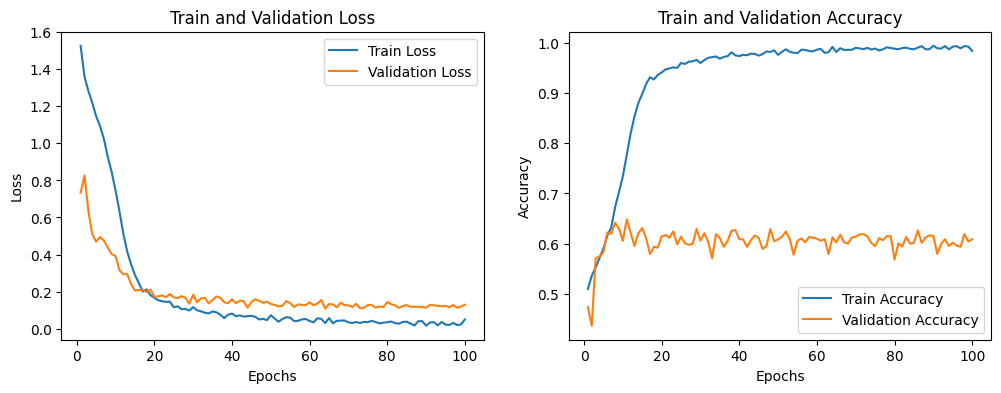

In [ ]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.show()

plot_history(history)

**Let's analyze the training plots for our ResNet50 model:--**

* Overfitting: The large gap between training accuracy (99%) and validation accuracy (65%) is a clear sign of overfitting - the model is performing well on training data but not generalizing well to new data.

* Early Plateauing: The validation accuracy plateaus early (around epoch 7) while training accuracy continues to improve, suggesting the model is memorizing training data rather than learning generalizable features.

# Testing the model:-

**Let's test our model on a single image picked randomly.**

/tmp/ipykernel_30/3020517046.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 0.6416


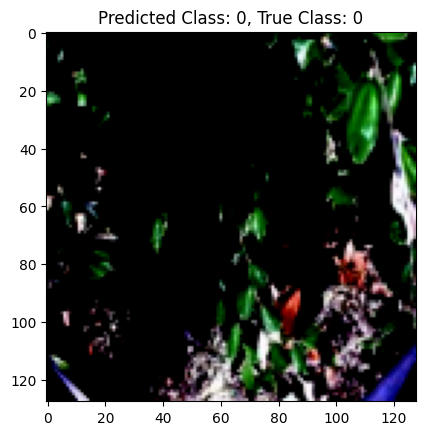

Predicted Class: 0
True Class: 0


In [ ]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set model to evaluation mode

# Create test loader (assumes a function `create_dataloader` exists)
test_loader = create_dataloader(loader_type='test')

# Evaluate model on the test set
test_correct = 0
test_total = 0

with torch.no_grad():  # Disable gradient calculation for testing
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)  # Get predictions
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy:.4f}')

# Choose a random image from the test loader and plot it
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use next() to get a batch

# Randomly select an image from the batch
random_index = np.random.randint(0, len(images))
image = images[random_index]
label = labels[random_index]

# Move the image to the appropriate device and make prediction
image_tensor = image.unsqueeze(0).to(device)
output = model(image_tensor)
_, predicted_class = output.max(1)

# Convert image to CPU and detach for plotting
image = image.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy array for plotting
image = np.clip(image, 0, 1)  # Normalize pixel values for display

# Plot the image
plt.imshow(image)
plt.title(f'Predicted Class: {predicted_class.item()}, True Class: {label.item()}')
plt.show()

# Print the predicted class
print(f"Predicted Class: {predicted_class.item()}")
print(f"True Class: {label.item()}")

#Evaluating our model further:-

**Let us further measure our model's performance by plotting the following matrices and evaluationg further.**

## Confusion Matrix:

A confusion matrix is a table that summarizes the performance of a classification model. It shows the number of true positives, true negatives, false positives, and false negatives for each class.

The rows represent the actual (true) classes, and the columns represent the predicted classes.

The diagonal elements indicate the correct predictions, while the off-diagonal elements represent the misclassifications.

Analyzing the confusion matrix can provide insights into the types of errors the model is making.

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, classes=None):
        self.data_frame = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = classes  # Adding classes attribute

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.data_frame.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define class names based on your dataset
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', ]  # Replace with your actual class names

# Initialize the test dataset with class names
test_dataset = ImageDataset(csv_file=test_csv_file, img_dir=img_dir, transform=transform, classes=class_names)

In [ ]:
print(test_dataset.classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8']


In [ ]:
import torch
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Switch the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
true_labels = []
pred_probs = []  # For storing probabilities

# Disable gradient calculations
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to the appropriate device
        images, labels = images.to('cuda'), labels.to('cuda')  # Assuming GPU is used

        # Forward pass
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # For multi-class probabilities

        # Append true labels and predicted probabilities
        true_labels.extend(labels.cpu().numpy())
        pred_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)

# Get predicted classes from probabilities
pred_classes = np.argmax(pred_probs, axis=1)

### Plotting Confusion Matrix-

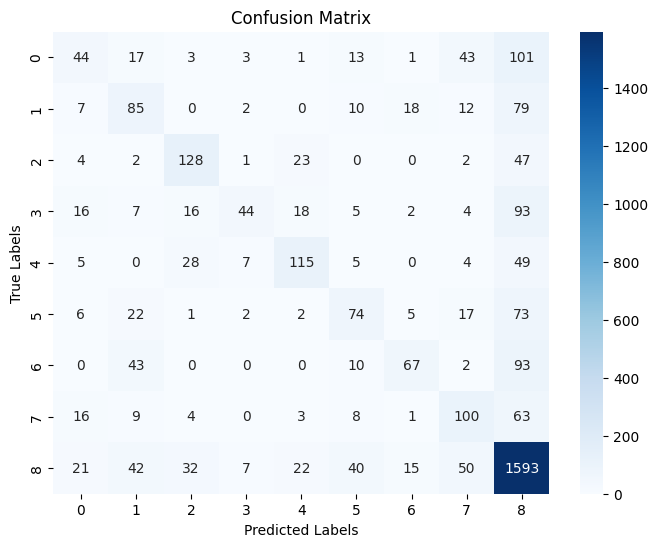

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Insights:**

* The model performs well on class 0 (44 correct predictions out of 44+17+3+3+1+13+1=82 total instances).
* The model struggles the most with class 2, confusing it with class 1 and class 3.
* The model also has some difficulty distinguishing between classes 3, 4, and 5.
The model performs reasonably well on classes 6, 7, and 8.
* Data Imbalance: The model might be trained on a dataset with imbalanced class distributions (e.g., Class 8 has many more samples than the others). This is evident from the large number of correct predictions for Class 8 compared to the rest.
* Feature Overlap: Misclassifications like Class 0 being predicted as Class 8 may indicate that features of these classes are similar. This could mean the model needs better feature extraction or more training data for certain classes.

Overall, the confusion matrix indicates that the model has room for improvement, especially in distinguishing between some of the harder-to-classify classes.

## ROC/AUC Curves:

The ROC (Receiver Operating Characteristic) curve shows the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity) for each class.

The area under the curve (AUC) is a summary metric that indicates the model's ability to distinguish between classes.
An AUC of 1 represents a perfect classifier, while an AUC of 0.5 represents a random classifier.

Analyzing the ROC curves can provide insights into the model's ability to differentiate between the different classes.

### Plotting ROC/AUC Curves-

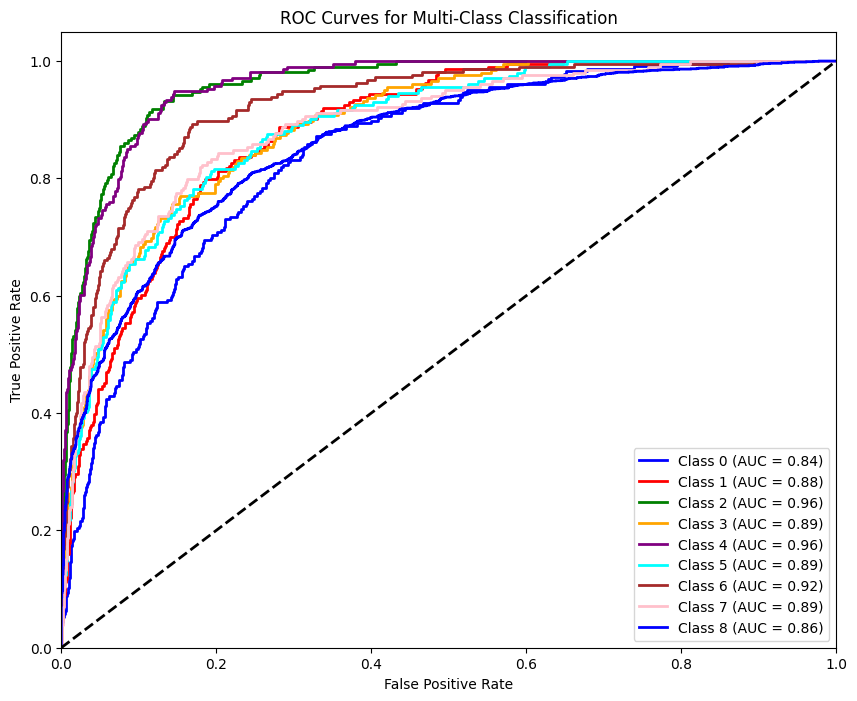

In [ ]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the true labels for multi-class ROC
num_classes = len(test_dataset.classes)
true_labels_bin = label_binarize(true_labels, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'brown', 'pink'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {test_dataset.classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

**Insights:**

* The plot demonstrates that the model performs best on class 8, as its ROC curve is the furthest from the diagonal (which represents random guessing). classes 0, 1, and 2 also have reasonably good ROC curves.
* However, the ROC curves for classes 3, 4, 5, 6, and 7 are closer to the diagonal, indicating that the model struggles to differentiate these classes from the others.
* The area under the curve (AUC) values for each class are shown in the legend, with class 8 having the highest AUC of 0.86, followed by classes 2, 4, and 6.

## F1-Score vs Recall:

This plot shows the relationship between the F1-score and recall for each class.It shows the F1-score (y-axis) versus the recall (x-axis) for each class.

The F1-score is a balance between precision and recall, while recall measures the model's ability to find all positive instances.

The ideal point would be in the top right corner, with high F1-score and high recall.

This plot can help identify classes where the model is struggling to balance precision and recall.

### Plotting F1-Score vs Recall-

/tmp/ipykernel_30/505622189.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


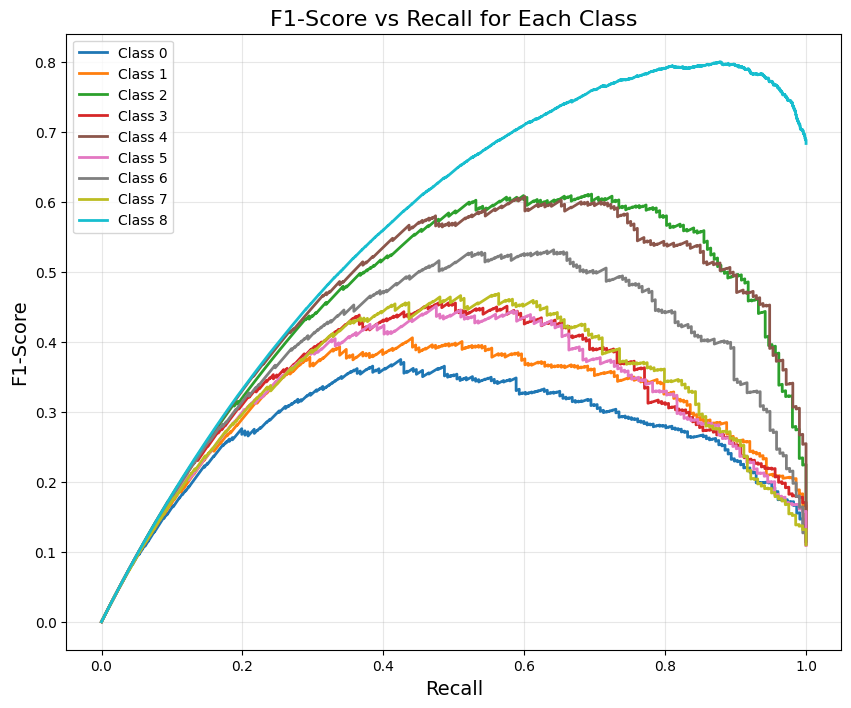

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Step 1: Define Test DataLoader (Replace 'test_dataset' with your dataset)
from torch.utils.data import DataLoader

batch_size = 16  # Adjust batch size as per your setup
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 2: Extract True Labels and Model Predictions
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # Set model to evaluation mode

test_labels = []
y_pred_probs = []

with torch.no_grad():  # No gradient computation during evaluation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # Move inputs to the same device as the model
        outputs = model(inputs)  # Get model predictions
        probs = F.softmax(outputs, dim=1).detach().cpu().numpy()  # Apply softmax
        y_pred_probs.extend(probs)  # Append probabilities
        test_labels.extend(labels.cpu().numpy())  # Append true labels

test_labels = np.array(test_labels)  # Convert to NumPy array
y_pred_probs = np.array(y_pred_probs)  # Convert to NumPy array

# Step 3: Prepare Data for Multi-Class F1-Score Calculation
num_classes = len(np.unique(test_labels))  # Number of classes
test_labels_bin = label_binarize(test_labels, classes=range(num_classes))  # Binarize true labels

# Step 4: Calculate Precision, Recall, and F1-Scores for Each Class
precision = {}
recall = {}
f1_scores = {}

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels_bin[:, i], y_pred_probs[:, i])
    f1_scores[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-4)  # Avoid division by zero

# Step 5: Plot F1-Score vs Recall
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', num_classes)

for i in range(num_classes):
    plt.plot(recall[i], f1_scores[i], label=f'Class {i}', color=colors(i), lw=2)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.title('F1-Score vs Recall for Each Class', fontsize=16)
plt.legend(loc='best', fontsize=10)
plt.grid(alpha=0.3)
plt.show()


**Insights:**

* This plot shows the F1-score (y-axis) versus the recall (x-axis) for each class. The ideal point would be in the top right corner, with high F1-score and high recall.
* The plot shows that the model performs best on class 8, with a high F1-score and recall. Classes 0, 1, and 2 also have reasonable F1-scores and recall values.

However, the plot also indicates that the model struggles with classes 3, 4, 5, 6, and 7, as they have much lower F1-scores and recall values.

### Classification report:

The classification report provides a summary of the key performance metrics for each class, as well as the overall accuracy.

The metrics included are:

* **Precision:** The fraction of true positive predictions out of all positive predictions. It measures the model's ability to avoid false positives.
* **Recall:** The fraction of true positive predictions out of all actual positive instances. It measures the model's ability to find all positive instances.
* **F1-score:** The harmonic mean of precision and recall, which provides a balanced metric.
* **Support:** The number of actual occurrences of the class in the test set.


These metrics help assess the model's performance on each class and identify any class-specific biases.

**Macro and Weighted F1-Score Calculation**

The **macro F1-score** is the unweighted mean of F1-scores across all classes, treating all classes equally.

The **weighted F1-score** accounts for class imbalance by weighing each class's F1-score by its support (the number of true samples in that class).

In [ ]:
from sklearn.metrics import f1_score, classification_report

# Step 6: Compute Overall Macro and Weighted F1-Scores
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Get predicted class labels
macro_f1 = f1_score(test_labels, y_pred_classes, average='macro')
weighted_f1 = f1_score(test_labels, y_pred_classes, average='weighted')

print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")

# Optional: Detailed Classification Report
print("\nClassification Report:\n")
print(classification_report(test_labels, y_pred_classes, target_names=[f"Class {i}" for i in range(num_classes)]))


Macro F1-Score: 0.4693
Weighted F1-Score: 0.6177

Classification Report:

              precision    recall  f1-score   support

     Class 0       0.37      0.19      0.26       226
     Class 1       0.37      0.40      0.39       213
     Class 2       0.60      0.62      0.61       207
     Class 3       0.67      0.21      0.32       205
     Class 4       0.62      0.54      0.58       213
     Class 5       0.45      0.37      0.40       202
     Class 6       0.61      0.31      0.41       215
     Class 7       0.43      0.49      0.46       204
     Class 8       0.73      0.87      0.79      1822

    accuracy                           0.64      3507
   macro avg       0.54      0.45      0.47      3507
weighted avg       0.63      0.64      0.62      3507



**Insights:**

The report shows that the model performs better on some classes than others, with class 8 having the highest precision, recall, and F1-score, while class 3 has the lowest.

The overall accuracy of the model is 0.54, which means it correctly classifies 54% of the instances. This is not a very high accuracy, indicating that the model has room for improvement.

## F1-Score per Class as a Bar Chart:

This plot shows the F1-score for each class, providing a visual summary of the model's performance on the different classes.

The F1-score is a useful metric that combines precision and recall, and it can help identify the classes where the model performs best and worst.

Analyzing this plot can guide efforts to optimize the model's performance, particularly for the classes with lower F1-scores.

### Plotting F1-Score per Class as a Bar Chart-

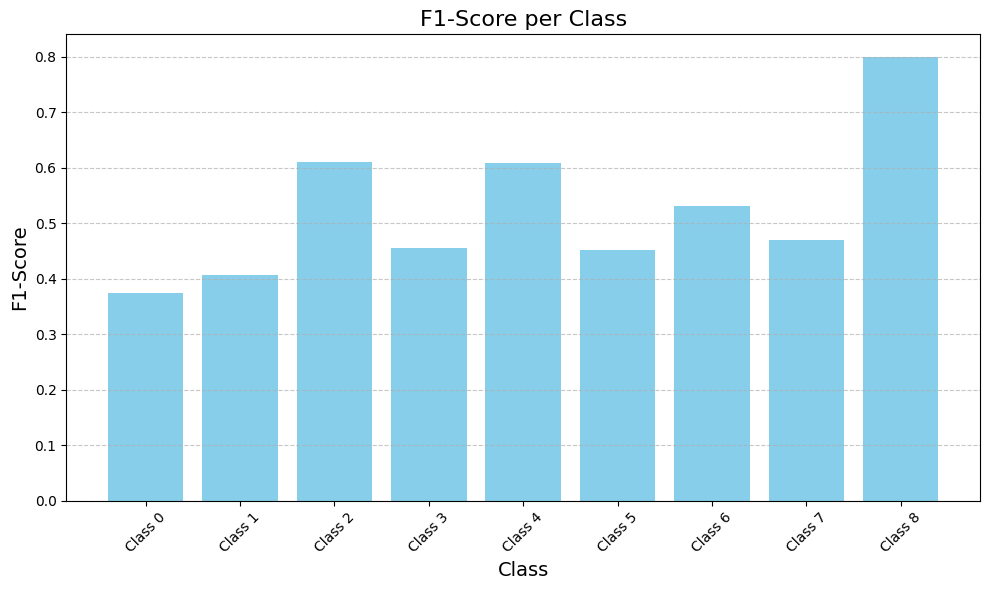

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Calculate F1-scores (you already have this from your previous code)
# (f1_scores dictionary should already be populated)

# Step 2: Plot Bar Chart for F1-scores
plt.figure(figsize=(10, 6))

# Create a bar plot using class index and its corresponding F1-score
plt.bar(range(num_classes), [f1_scores[i].max() for i in range(num_classes)], color='skyblue')

# Add labels and title
plt.xlabel('Class', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.title('F1-Score per Class', fontsize=16)
plt.xticks(range(num_classes), [f"Class {i}" for i in range(num_classes)], rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


**Insights:**

The plot clearly shows that class 8 has the highest F1-score, followed by classes 2, 1, and 0. The model performs the worst on classes 3, 4, 5, 6, and 7, with much lower F1-scores.

This information, along with the insights from the other evaluation matrices, can help you identify the areas where the model needs the most improvement and guide your efforts to optimize its performance.

## Overall Model Performance Interpretation:-

Overall, the evaluation matrices suggest that the model performs well on some classes but has difficulty with others, particularly classes 3, 4, 5, 6, and 7.

Focusing on improving the model's performance on these harder-to-classify classes could be a priority for further model development and optimization.

#Next Steps:-

* In the next 2 notebooks we'll experiment with the below 2 techniques to find out how our model performs:

  * Explore **data augmentation** techniques to help the model generalize better.

  * Apply **pre-trained weights** during training to address imbalance.

  * In both the cases, we'll also:
    * increase the batch size to 32
    * change the learning rate to 1e-3
    * replace dropout with **regularization**

* After that in our **4th & 5th** notebooks, we'll test our dataset using pretrained ResNet-34 and Inception-v3 models, fine tune them and compare their results.